In [1]:
!cd .. && git submodule init
!cd .. && git submodule update
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python3)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python3 --version

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /usr/bin/python3 (found version "3.8.2") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/lisandro/Documents/mt/tp2
-- Configuring done
-- Generating done
-- Build files have b

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import metnum as mt
import os
import seaborn as sns
from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score

In [3]:
#neighbors for finding the mode in KNN
N_NEIGHBORS = 100
#components for PCA
N_COMPONENTS=40
#number of iterations to find eigenvalues and eigenvectors in power iteration
N_ITERATIONS=5000
#epsilon for power iteration
EPSILON=1e-10
#Training / testing percentage
limit = int(0.8 * 42000) 

df_train = pd.read_csv("/home/lisandro/Documents/mt/tp2/data/train.csv")

#shuffle the train cases.
df_train = df_train.sample(frac=1)

# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

X_train, y_train = X[:limit], y[:limit]
X_test, y_test = X[limit:], y[limit:]

assert len(X_train) == len(y_train)
assert len(X_test) == len(y_test)

print(f"Ahora tengo {len(X_train)} instancias de entrenamiento y {len(X_test)} de validación")

Ahora tengo 33600 instancias de entrenamiento y 8400 de validación


### Experimentacion kNN vs PCA + kNN para igual cantidad de componentes

### testeo PCA para valores entre 1 y 10 con train / total data = 0.85 y set completo

In [18]:
%%time
from time import time

limit = int(0.85 * 42000)

alphas = [i for i in range(1,70)]
accs = []
cohens = []
times = []

for alpha in alphas:
    start_time = time()
    
    df_train = pd.read_csv("/home/lisandro/Documents/mt/tp2/data/train.csv")

    #shuffle the train cases.
    df_train = df_train.sample(frac=1)

    X = df_train[df_train.columns[1:]].values
    y = df_train["label"].values.reshape(-1, 1)
    
    pca = mt.PCA(alpha,N_ITERATIONS,EPSILON)
    pca.fit(X)
    X_pca = pca.transform(X)
    
    X_train, y_train = X_pca[:limit], y[:limit]
    X_test, y_test = X_pca[limit:], y[limit:]
    
    clf = mt.KNNClassifier(3)
    clf.fit(X_train,y_train)
    pred = clf.predict(X_test)
    
    end_time = time()
    
    accs.append(accuracy_score(pred,y_test))
    cohens.append(cohen_kappa_score(pred,y_test))
    times.append(end_time - start_time)

CPU times: user 33min 9s, sys: 33.1 s, total: 33min 42s
Wall time: 33min 39s


In [35]:
df_train = pd.read_csv("/home/lisandro/Documents/mt/tp2/data/train.csv")

#shuffle the train cases.
df_train = df_train.sample(frac=1)

# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

limit = int(0.85 * 42000)

X_train, y_train = X[:limit], y[:limit]
X_test, y_test = X[limit:], y[limit:]

clf = mt.KNNClassifier(3)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)

print(accuracy_score(pred,y_test))

knn_sin_pca = [accuracy_score(pred,y_test) for i in range (1,70)]

0.964920634920635


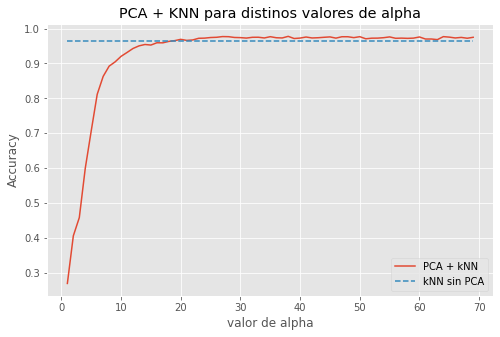

In [49]:
plt.figure(figsize=(8,5))
plt.style.use('ggplot')
plt.plot(alphas, accs)
plt.plot(alphas, knn_sin_pca, linestyle = 'dashed')
# plt.plot(alphas, times)
plt.xlabel('valor de alpha')
plt.ylabel('Accuracy')
plt.title('PCA + KNN para distinos valores de alpha')
plt.savefig("3_fold_cross_validation_cant_vecinos.jpg")
plt.legend(['PCA + kNN', 'kNN sin PCA'])

plt.savefig('pca_knn_dist_alpha_acc')

In [53]:
%%time
df_train = pd.read_csv("/home/lisandro/Documents/mt/tp2/data/train.csv")

#shuffle the train cases.
df_train = df_train.sample(frac=1)

# Uso values para mandar todo a arrays de numpy
X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)

limit = int(0.85 * 42000)

X_train, y_train = X[:limit], y[:limit]
X_test, y_test = X[limit:], y[limit:]

clf = mt.KNNClassifier(3)
clf.fit(X_train,y_train)
pred_cohens = clf.predict(X_test)

print(cohen_kappa_score(pred_cohens ,y_test))

knn_sin_pca_cohen = [cohen_kappa_score(pred_cohens ,y_test) for i in range (1,70)]

0.9638371163237744
CPU times: user 4min 55s, sys: 473 ms, total: 4min 56s
Wall time: 4min 55s


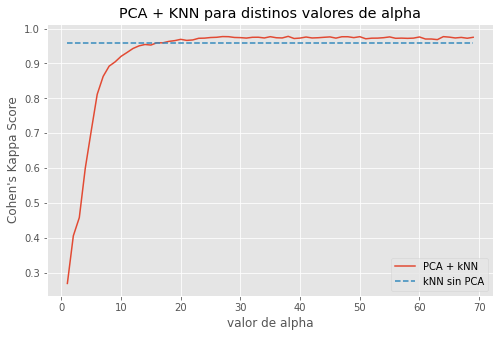

In [52]:
plt.figure(figsize=(8,5))
plt.style.use('ggplot')
plt.plot(alphas, accs)
plt.plot(alphas, knn_sin_pca_cohen, linestyle = 'dashed')
# plt.plot(alphas, times)
plt.xlabel('valor de alpha')
plt.ylabel('Cohen\'s Kappa Score')
plt.title('PCA + KNN para distinos valores de alpha')
plt.savefig("3_fold_cross_validation_cant_vecinos.jpg")
plt.legend(['PCA + kNN' , 'kNN sin PCA'])

plt.savefig('pca_knn_dist_alpha_acc_cohen')

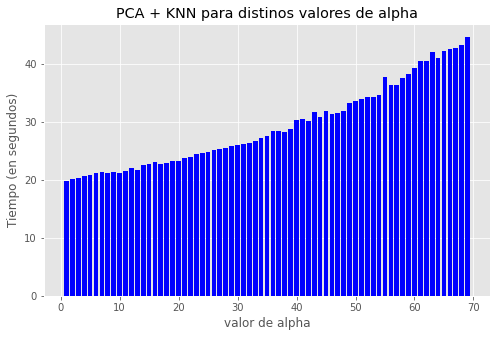

In [34]:
plt.figure(figsize=(8,5))
plt.style.use('ggplot')
plt.bar(alphas, times, color = 'blue')
plt.xlabel('valor de alpha')
plt.ylabel('Tiempo (en segundos)')
plt.title('PCA + KNN para distinos valores de alpha')
plt.savefig("pca_knn_tiempo")



In [54]:
limit = int(0.85 * 42000)

start_time = time()
    
df_train = pd.read_csv("/home/lisandro/Documents/mt/tp2/data/train.csv")

#shuffle the train cases.
df_train = df_train.sample(frac=1)

X = df_train[df_train.columns[1:]].values
y = df_train["label"].values.reshape(-1, 1)
    
pca = mt.PCA(25,N_ITERATIONS,EPSILON)
pca.fit(X)
X_pca = pca.transform(X)
    
X_train, y_train = X_pca[:limit], y[:limit]
X_test, y_test = X_pca[limit:], y[limit:]
    
clf = mt.KNNClassifier(3)
clf.fit(X_train,y_train)
pred = clf.predict(X_test)
    
end_time = time()

print(end_time - start_time)

25.693418741226196
